In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Nsteps = 4500	# total number of time steps
Nx = 256		# number of computational grids in x-direction
Ny = 128			# number of computational grids in y-direction
dx, dy = 5.e-5, 5.e-5		# spacing of computational grid [m]
eee = 0.		# chemical driving force [J/m3]
sigma = 1.0		# ineterfacial energy [J/m2]
amobi = 1.e-7	# interfacial mobilitiy [m4/(Js)]
delta = 6.*dx	# interfacial thickness [m]
ram = 0.1		# paraneter which deternines the interfacial area

bbb = 2.*np.log((1.+(1.-2.*ram))/(1.-(1.-2.*ram)))/2.	# constant b = 2.1972
aaa = np.sqrt(3.*delta*sigma/bbb)		# gradient energy coefficient  "a" [(J/m)^(1/2)]
www = 6.*sigma*bbb/delta				# potential height W [J/m3]
pmobi = amobi*np.sqrt(2.*www)/(6.*aaa)	# phase-field mobility [m3/(Js)]
dt = dx*dx/(5.*pmobi*aaa*aaa)/2.		# time increment for a time step [s]

In [3]:
Nq  = 9				# number of velocities (e.g. Nq = 9 for D2Q9 model)
nu  = 0.2			# kinematic viscosity
tau = 3.*nu + 0.5	# relaxation time
rho0= 1.			# initial density
ux0 = 0.1			# inlet velocity in x-direction
uy0 = 0.			# inlet velocity in y-direction

In [4]:
p = np.zeros((Nx,Ny))		# PF variable
p_new = np.zeros((Nx,Ny))	# PF variable at next time step
F  = np.ones((Nx,Ny,Nq))	# velocity distribution function
cx = np.array([0, 1, 0,-1, 0, 1,-1,-1, 1])	# discrete velocities (x-dir.)
cy = np.array([0, 0, 1, 0,-1, 1, 1,-1,-1])	# discrete velovities (y-dir.)
wt = np.array([4./9.,1./9.,1./9.,1./9.,1./9.,1./36.,1./36.,1./36.,1./36.])	# weighting coefficients

In [5]:
def solve_allen_cahn(p, p_new):
	p_new[1:-1, 1:-1] = p[1:-1, 1:-1] + pmobi * ( 4.*www*p[1:-1, 1:-1]*(1.-p[1:-1, 1:-1])*(p[1:-1, 1:-1]-0.5+3./(2.*www)*eee) + aaa*aaa*( (p[2:, 1:-1] - 2*p[1:-1, 1:-1] + p[:-2, 1:-1])/dx/dx                                                +(p[1:-1, 2:] - 2*p[1:-1, 1:-1] + p[1:-1, :-2])/dy/dy) ) * dt
	p_new[0,:]    = p_new[1,:]
	p_new[-1,:] = p_new[-2,:]
	p_new[:,0]    = p_new[:,-2]
	p_new[:,-1] = p_new[:,1]    
	p[:,:] = p_new[:,:]

In [6]:
def solve_LBM(F, rho, ux, uy):
	# collision step
	Feq = np.zeros(F.shape)	# local equilibrium distribution
	for i in range(0,Nq):
		Feq[:,:,i] = rho * wt[i] * ( 1. + 3.*(cx[i]*ux+cy[i]*uy) + 9./2.* (cx[i]*ux+cy[i]*uy)**2 - 3./2.*(ux**2+uy**2) )

	G = np.zeros(F.shape)	# dissipative drag force
	Gx = (4. * 2.757 * rho * nu * bbb**2 * p**2 / (delta/dx)**2) * ux
	Gy = (4. * 2.757 * rho * nu * bbb**2 * p**2 / (delta/dx)**2) * uy
	for i in range(0,Nq):
		G[:,:,i] = rho * wt[i] * ( 3.*((cx[i]-ux)*Gx+(cy[i]-uy)*Gy) + 9.*(cx[i]*ux+cy[i]*uy)*(cx[i]*Gx+cy[i]*Gy) )

	F += -1./tau * (F - Feq) - G	

	# streaming step
	for i in range(Nq):
		F[:,:,i] = np.roll(F[:,:,i], cx[i], axis=0)
		F[:,:,i] = np.roll(F[:,:,i], cy[i], axis=1)

	# boundary conditions
	rhow = 1./(1.-ux0)*( F[0,:,0]+F[0,:,2]+F[0,:,4]+2*(F[0,:,3]+F[0,:,6]+F[0,:,7]) )
	F[0,:,1] = F[0,:,3] + 2./3.*rhow*ux0	# left boundary (inlet velocity: ux0 & uy0)
	F[0,:,5] = F[0,:,7] - 1./2.*(F[0,:,2] - F[0,:,4]) + 1./6.*rhow*ux0 + 1./2.*rhow*uy0
	F[0,:,8] = F[0,:,6] + 1./2.*(F[0,:,2] - F[0,:,4]) + 1./6.*rhow*ux0 - 1./2.*rhow*uy0

	F[-1,:,3]=F[-2,:,3]	# right boundary (Zero-Neumann)
	F[-1,:,6]=F[-2,:,6]
	F[-1,:,7]=F[-2,:,7]

In [7]:
r_nuclei = (Ny-1)*dx/4.	# initial radius of the solid phase
for i in range(0,Nx):
	for j in range(0,Ny):
		r = np.sqrt( (i*dx-(Nx-1)*dx/4)**2 + (j*dy-(Ny-1)*dx/2.)**2 ) - r_nuclei
		p[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*aaa)*r))

for i in range(0,Nq):	# determine initial distribution functions: local equilibrium with constant velocities ux0 & uy0
	F[:,:,i] = rho0 * wt[i] * ( 1. + 3.*(cx[i]*ux0+cy[i]*uy0) + 9./2.* (cx[i]*ux0+cy[i]*uy0)**2 - 3./2.*(ux0**2+uy0**2) )

rho = np.sum(F,2)		# calculate initial fluid variables
ux  = np.sum(F*cx,2) / rho
uy  = np.sum(F*cy,2) / rho
uu  = np.sqrt(ux**2+uy**2)

Nstep = 1 , Re = 31.84


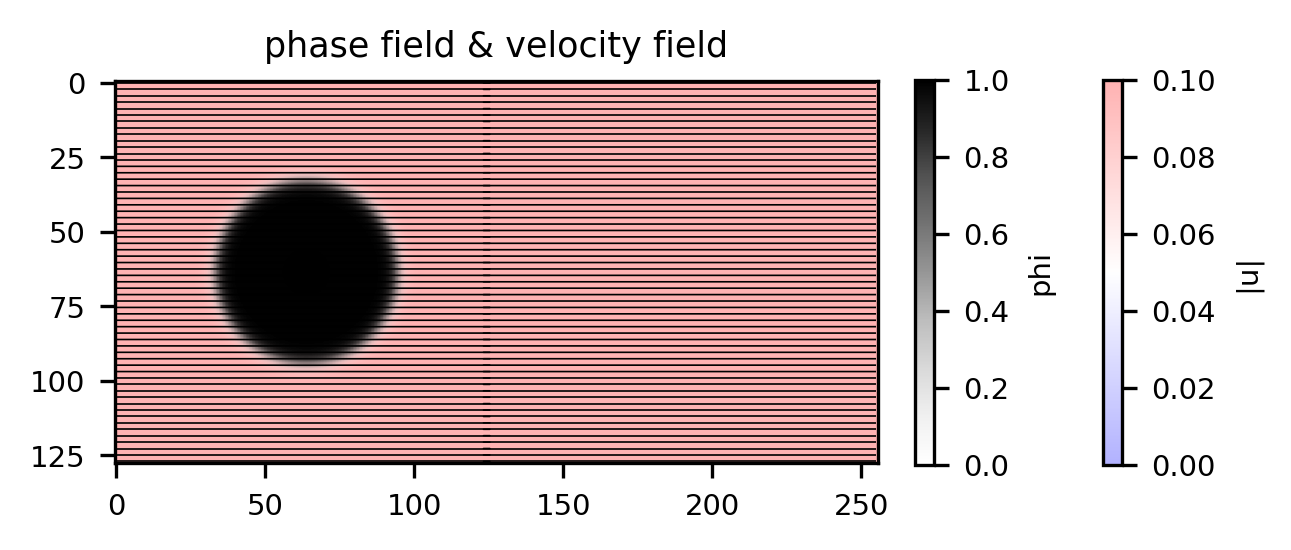

Nstep = 500 , Re = 30.25


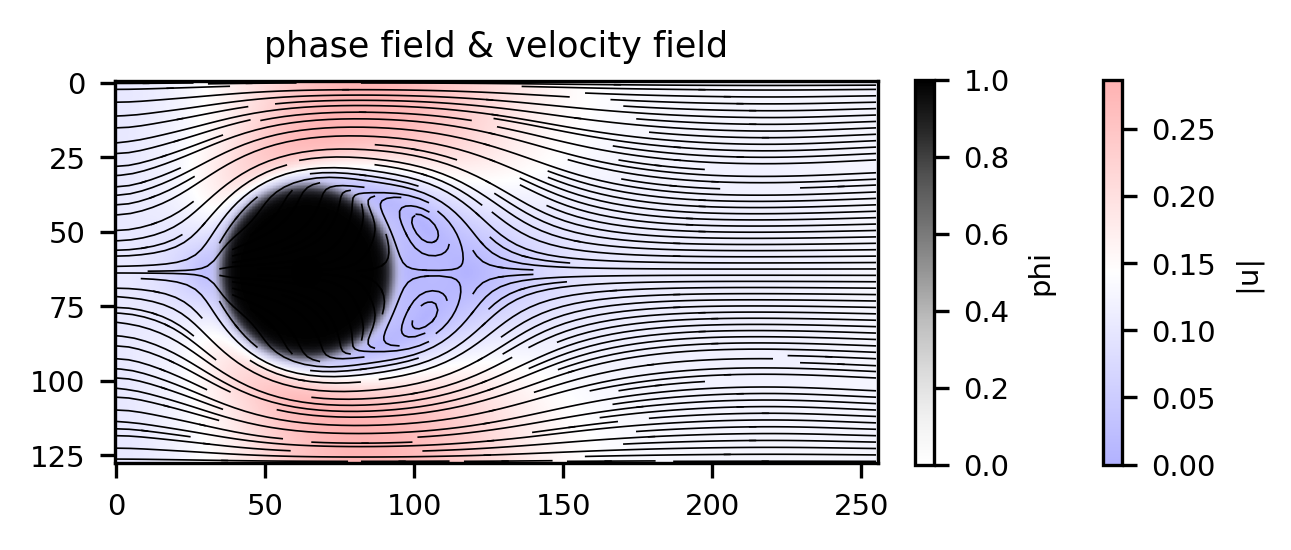

Nstep = 1000 , Re = 28.57


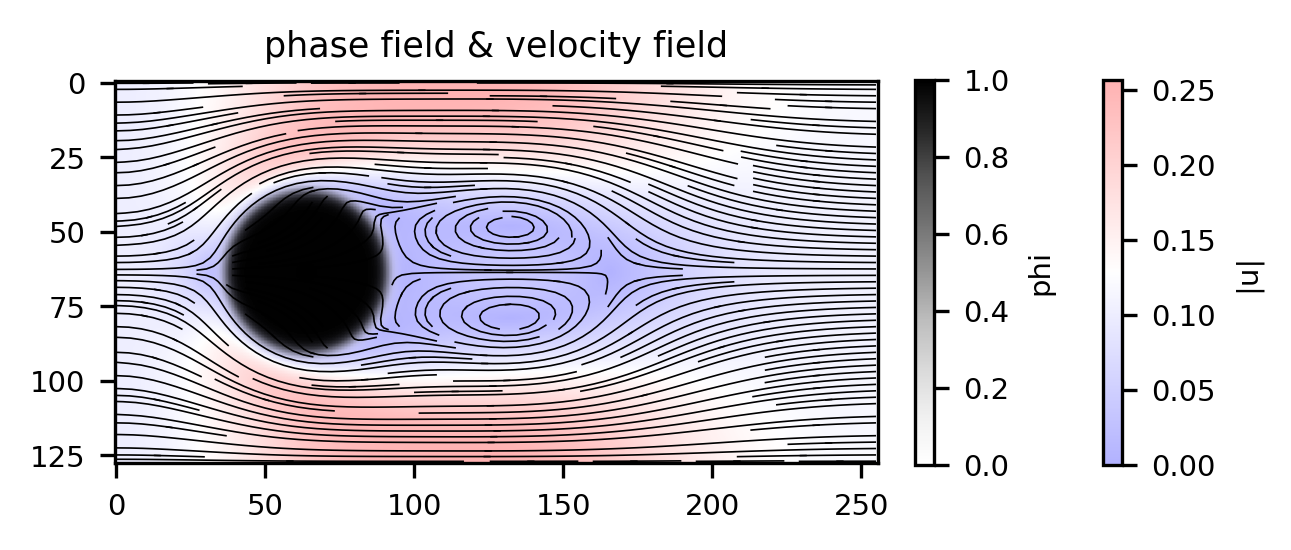

Nstep = 1500 , Re = 26.78


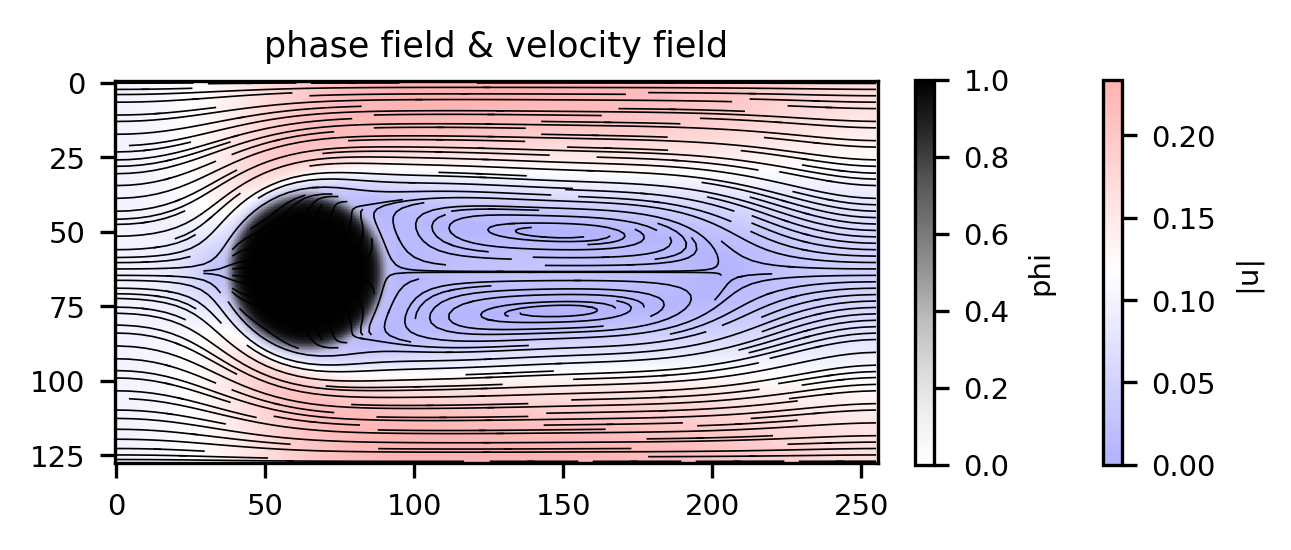

Nstep = 2000 , Re = 24.87


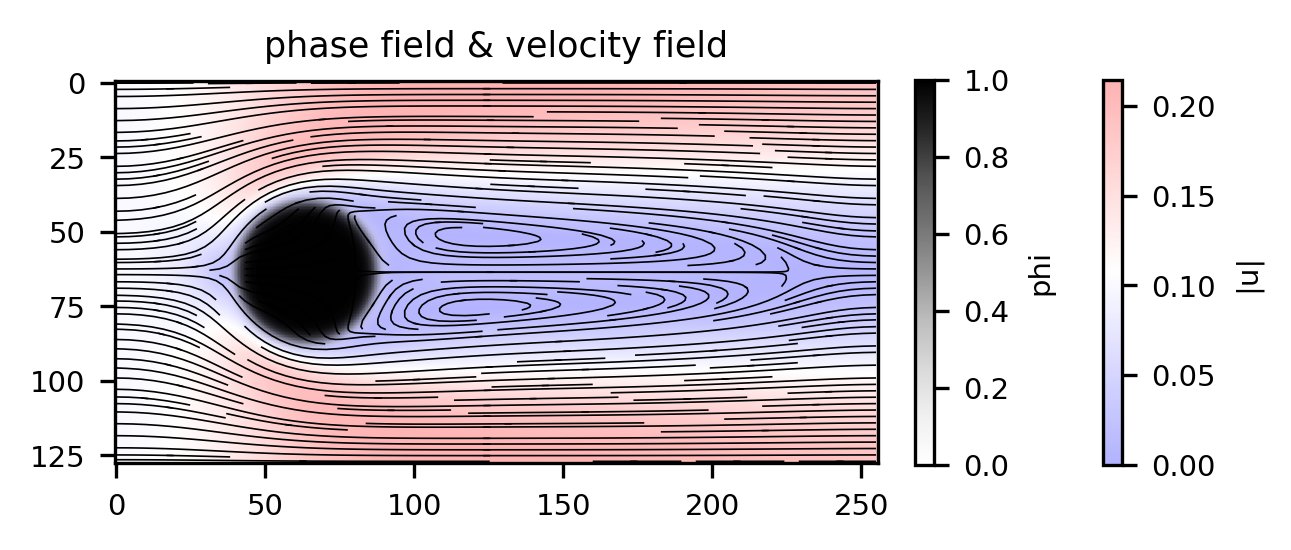

Nstep = 2500 , Re = 22.79


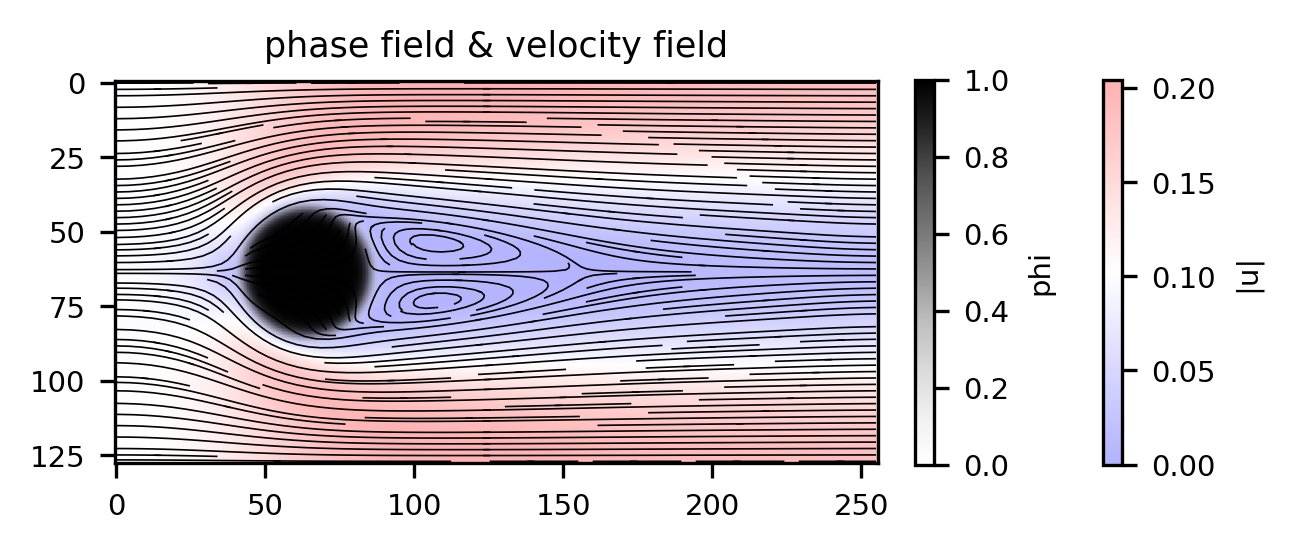

Nstep = 3000 , Re = 20.50


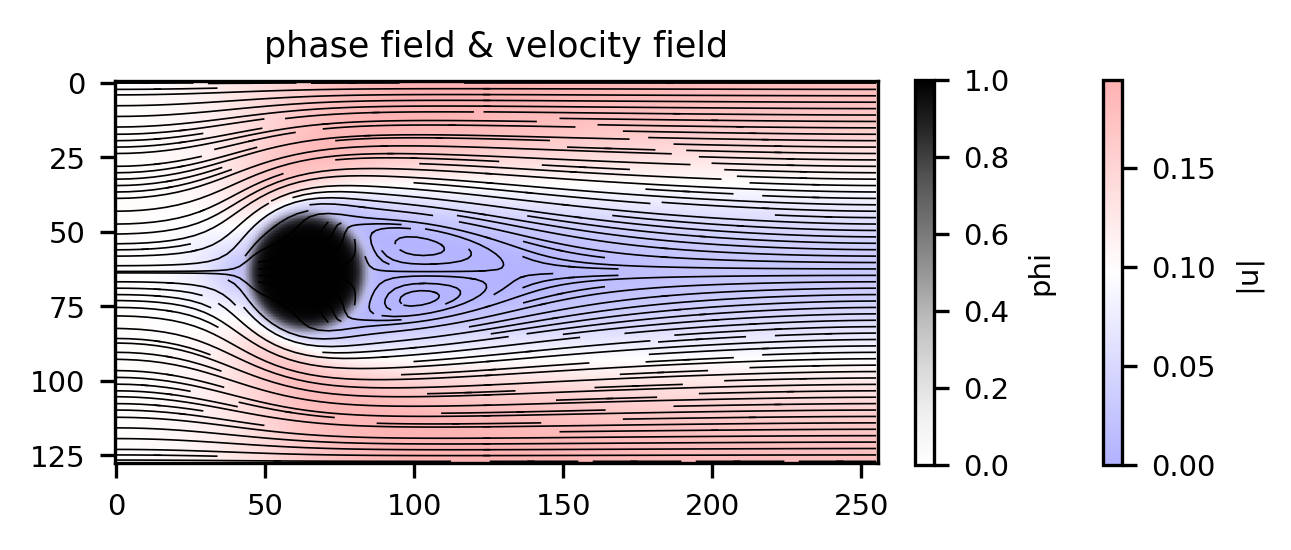

Nstep = 3500 , Re = 17.92


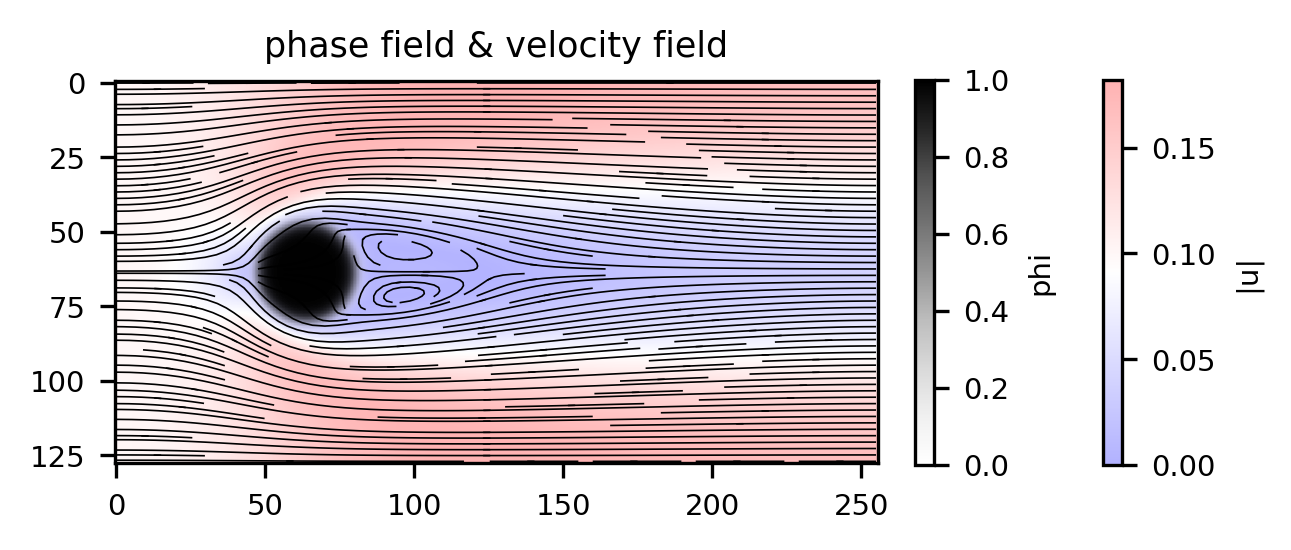

Nstep = 4000 , Re = 14.88


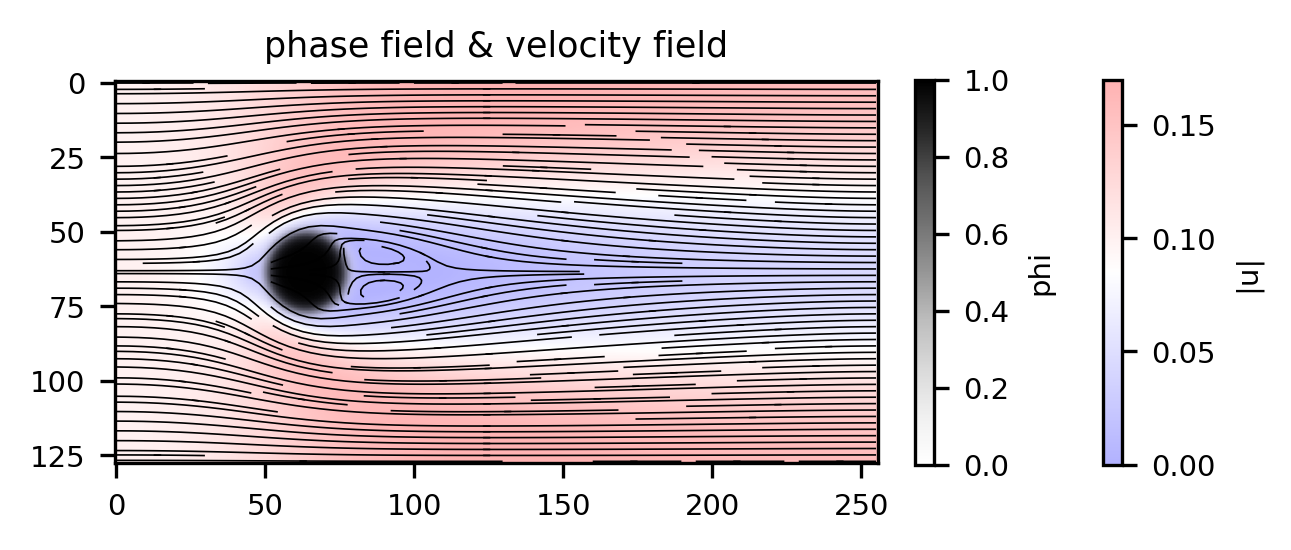

Nstep = 4500 , Re = 11.02


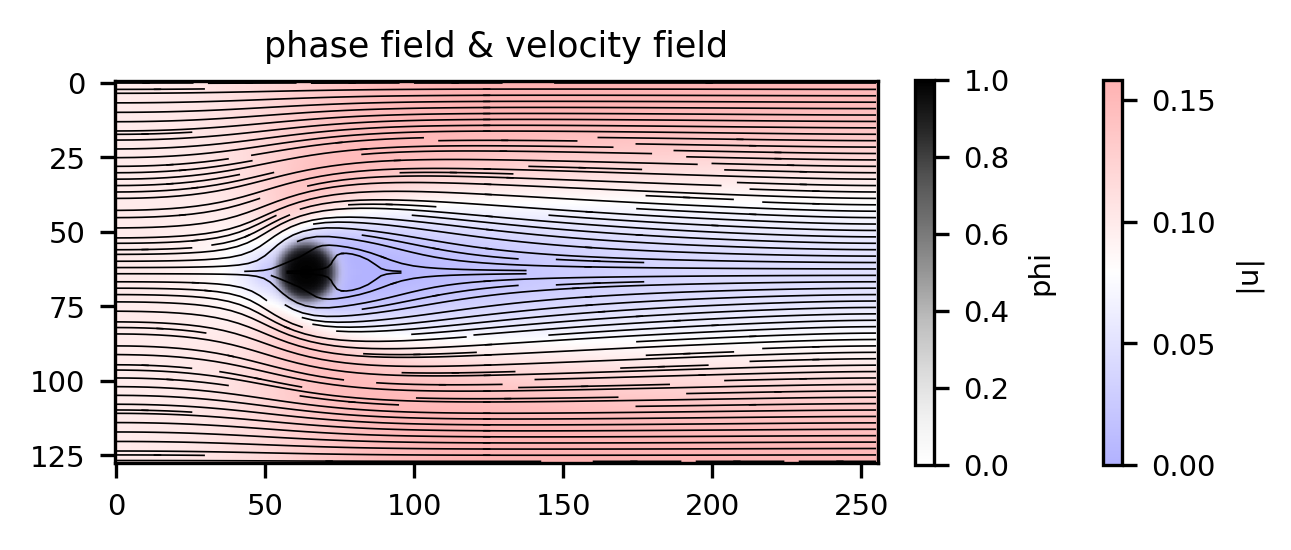

In [8]:
for t in range(1, Nsteps+1):

	solve_LBM(F, rho, ux, uy)
	solve_allen_cahn(p, p_new)

	### calculate fluid variables
	rho = np.sum(F,2)
	ux  = np.sum(F*cx,2) / rho
	uy  = np.sum(F*cy,2) / rho
	uu  = np.sqrt(ux**2+uy**2)

	### calculate Reynolds number (Re)
	A_s = np.sum(p)				# area of solid
	D_s = 2.*np.sqrt(A_s/np.pi)	# diameter of solid
	Re  = D_s*ux0 / nu 
    
	if t % 500 == 0 or t == 1:
		print("Nstep =", t, ", Re =", "{:.2f}".format(Re))
		x = np.arange(Nx)
		y = np.arange(Ny)
		xx, yy = np.meshgrid(range(Nx), range(Ny))

		fig = plt.figure(figsize=(5,2.5))
		fig.set_dpi(300)
		plt.rcParams["font.size"] = 7

		plt.title('phase field & velocity field')	
		plt.imshow(uu.T, cmap='bwr', vmin=0, alpha=0.3)
		plt.colorbar(label='|u|', aspect=20, pad=0.04, shrink=2./3.)
		plt.imshow(p.T, cmap='Greys', vmin=0, vmax=1, alpha=p.T)
		plt.colorbar(label='phi', aspect=20, pad=0.04, shrink=2./3.)
		plt.streamplot(xx, yy, ux.T, uy.T, density=2, color='k', arrowstyle='-', linewidth=0.4)	
		plt.show()

# Depending on your compilation environment, the line "plt.imshow(p.T, cmap='Greys', vmin=0, vmax=1, alpha=p.T)" may cause an error.
# In that case, please replace the visualization part of p and uu with the following.

#		plt.imshow(p.T, cmap='Greys', vmin=0, vmax=1)
#		plt.colorbar(label='phi', aspect=20, pad=0.04, shrink=2./3.)
#		plt.imshow(uu.T, cmap='bwr', vmin=0, alpha=0.2)
#		plt.colorbar(label='|u|', aspect=20, pad=0.04, shrink=2./3.)